# Explanation on generator design choices. 

**Don't look if you don't want spoilers!**

This notebook covers the design choices of the [data generator](#Data-generator) (and [changes for the regenerator](#Data-re-generator). If you're looking for an exploratory analysis of the data, look **HERE**. If you're looking for the experimental plan and analysis, look **HERE**.

### Why we need a generator

**Why I wanted to do this project**

Before I learned to program / decided I wanted to learn to do data science, I ran user-testing programs for hardware products at a tech company. There are a lot of people getting into data science, and while I still feel like a beginner at programming, I'm pretty confident in my business background. So I wanted a project to show that. When I first started, this project had almost nothing to do with business, but it just kind of bled through - the connections were already there.

--> so maybe it's better to just say that? think about the message and try to get it clear.
--> I also like this stuff anyway - ask me about the case study I wrote for a business fraternity in 2018. (I picked this restaurant because I thought the name was funny - I was going to use another restaurant I also wrote a case about called the Himalayan Chimney, but they changed their website to just an ordering screen because of covid, which wasn't as fun).

**Showcasing A/B testing is hard**

Anyway, it's hard to showcase A/B testing because you need a product and users. And every company seems to want A/B testing experience. So instead of giving up, I found a sneaky way around it. When a company does A/B testing, they just look at the data to see how users interact with a change. So instead of actually implementing a change and looking at the data, we can just regenerate data for a month and pretend that's the sales data from the users. It's just order data, so it's not as good as real-time user data (like click-through-rates or stuff like that), but it's not likely most restaurants will have that kind of data either - it's a nice, simple example.

--> also gives us a chance to talk about the difference between a/b testing and other types of user testing
--> don't forget about the pitfalls of A/B testing! How does that apply to this case?

**Notebooks are independent**

In each workbook, we assume we have no knowledge of other notebooks.

A truer chronological workflow might look like this:

1. Get data
    1. Write generator, generate data [data_generator.py]
    2. Document generator design [generator_explanation.ipynb]
    
    
2. Explore data
    1. Explore, validate data (suggest business recs / potential tests) [data_analysis.ipynb]
    
    
3. Design test
    1. Design experiment for accepted tests [experiment_analysis.ipynb]
    
    
4. Implement test
    1. Regenerate data for test [data_generator.py]
    2. Document re-generator design [generator_explanation.ipynb]
    
    
5. Evaluate findings
    1. Analyze experiment, explain findings [experiment_analysis.ipynb]

# Setup

Essentially the same setup that happens in the analysis - we need this to validate our generator later.

In [1]:
import pandas as pd
pd.options.display.max_rows = 10  # limit huge ouputs
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')  # plt.style.available

import warnings
warnings.filterwarnings("ignore")  # filter warnings

In [2]:
path = "../data/raw_data/"

all_months_data = pd.DataFrame()

for file in os.listdir(path):
    if not file.startswith('.'):  # ignore hidden files
        current_month_data = pd.read_csv(path+file)
        all_months_data = pd.concat([all_months_data, current_month_data])

# remove unnamed column (fixed for future generations!)
df = all_months_data.loc[:, ~all_months_data.columns.str.contains('^Unnamed')]

In [3]:
# add sales, datetime columns to filter by

df['Order Date'] = pd.to_datetime(df['Order Date'])

df['Sales'] = df['Quantity Ordered'] * df['Price Each']

df['Year'] = df['Order Date'].dt.year

df['Month'] = df['Order Date'].dt.month

df['Weekday'] = df['Order Date'].dt.day_name()

df['Weekday Value'] = df['Order Date'].dt.weekday

df['Hour'] = df['Order Date'].dt.hour

df['Day of Month'] = df['Order Date'].dt.day

![](..\\revenue_model.jpg)

<!-- This is an extra model so I can see it while I'm typing - don't forget to remove! -->

# Data generator

# Conceptual revenue model

We don't have ThaiTanic's actual data, but we can can get pretty close by paying attention to public information about their business. Let's consider a revenue model for the restaurant.

![](..\\revenue_model.jpg)

Their revenue is basically the number of orders times the cost per order. There's a bunch of stuff that affects those two factors, so we'll look at them one at a time:

1. How many orders does the restaurant get per month?
2. What do people spend on orders?

We can answer the first through market sizing, and the second by making our best guess based on what's on their menu (I asked some friends for input too!). And then we'll add some random variation to the values.

--> can probably move this to the individual sections

### (!) Our goal is to output monthly csvs that are realistic to the data

Why monthly? It seems pretty reasonable to me.

### (!) we could go even further by creating expense values, but that seems a bit out of scope

# (!) there's some component of how long a meal takes...

ALSO DO I ADD TAKEOUT TO THE MODEL?

# 1. How many orders does the restaurant get per month?

We can answer this by using some market sizing tricks.

__Order:__
1. Market sizing
    1. Seating count
    2. Dining time
    3. Delivery/takeout

    
2. Popular times (we generate by hour!)

4. Annual, seasonal multipliers
    1. Annual multiplier --> just make future years slightly bigger to show growth over time
    2. Seasonal multiplier --> winter months are max?

### Market sizing

Seating count, dining time, delivery/takeout

We can estimate their maximum realistic income...

### Seating: estimate dine-in capacity

Eyeballing the pictures, it looks like there are 4 + 4 + 2 + 2 + 2 + 3 indoor seats and 4 + 4 outdoor seats. ==> 13ish indoor seats, and 8 outdoor seats. ==> 21ish seats.

I don't think outdoor seats are as popular so I'm okay with rounding down to 20 seats. 

[ThaiTanic street view (Google Earth)](https://earth.google.com/web/search/ThaiTanic+Streetfood,+Bridgeway,+Sausalito,+CA/@37.85851259,-122.48337616,3.31408215a,0d,60y,258.6686533h,78.86489434t,0r/data=CpkBGm8SaQolMHg4MDg1ODQ1MWI0ZjE4YTkxOjB4YTU2MWViNDU4NTcyMWU5ZBl0mfW94e1CQCG4HK9A9J5ewCouVGhhaVRhbmljIFN0cmVldGZvb2QsIEJyaWRnZXdheSwgU2F1c2FsaXRvLCBDQRgBIAEiJgokCUlFdQiQmTZAEUdFdQiQmTbAGda0jUD-tz1AIQtYmNuq1VLAIhoKFlNMblNLNWVpQURnbUg4SlN3MzZoTmcQAg)

[ThaiTanic aerial view (Google Earth)](https://earth.google.com/web/search/ThaiTanic+Streetfood,+Bridgeway,+Sausalito,+CA/@37.85845058,-122.4836834,2.8947445a,41.80733363d,35y,-45.474136h,27.45597896t,360r/data=CpkBGm8SaQolMHg4MDg1ODQ1MWI0ZjE4YTkxOjB4YTU2MWViNDU4NTcyMWU5ZBl0mfW94e1CQCG4HK9A9J5ewCouVGhhaVRhbmljIFN0cmVldGZvb2QsIEJyaWRnZXdheSwgU2F1c2FsaXRvLCBDQRgBIAEiJgokCUlFdQiQmTZAEUdFdQiQmTbAGda0jUD-tz1AIQtYmNuq1VLA)

### Takeout capacity

I didn't have a good way to estimate takeout, so I just added 50% to the seating count. It seemed unrealistic to do not account for it, and doubling seating felt like too much. So our 20 seats became 30 seats.

### how long does a meal take?

Google indicates people typically spend 15 minutes to 1 hour here. The restaurant is open about 8 hours a day.

It feels too short to use 30 minutes as an average (even though some of the meals are during lunch hour or are takeout), and 1 hour feels too long, so I'm okay with 45. I don't know much about kitchen capacity or prep, but that seems reasonable to me. It seems like a sit-down place.

They're open 8 hours a day, so 8/0.75 is 10.66, we can just round that to 11 meals per hour.

So 30 seats * 11 meals per hour is an average of 330 orders per day. How close are we to that? We should definitely below that because that's the ceiling

==> in n out for reference?




==> We can use Google's popular times to estimate occupancy by the hour. If we didn't have this, we could either estimate by hour, or just randomize by day or something. 



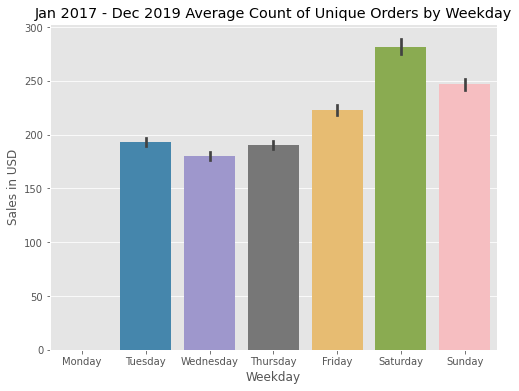

In [8]:
# show average count of unique orders per weekday

weekday_sales_without_monday = orders_per_day = df.groupby(['Year', 'Month', 'Day of Month', 'Weekday Value', 'Weekday']
                                                          ).nunique().reset_index()
weekday_sales_without_monday = weekday_sales_without_monday.sort_values(by='Weekday Value')  # keep weekday order

weekday_sales = pd.DataFrame(columns=weekday_sales_without_monday.columns)
monday_row = {'Weekday': 'Monday', 'Sales': 0}  # show mondays are closed

weekday_sales = weekday_sales.append(monday_row, ignore_index=True)
weekday_sales = pd.concat([weekday_sales, weekday_sales_without_monday]).reset_index(drop=True)

plt.figure(figsize=(8,6))
ax = sns.barplot(data=weekday_sales, x='Weekday', y='Order ID')

# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')  # rotate if small figsize
plt.title("Jan 2017 - Dec 2019 Average Count of Unique Orders by Weekday")
plt.ylabel("Sales in USD");

this is what we were expecting - 330 is the maximum amount of orders the restaurant could serve in a day. If they had nonstop demand (lines out the door) all day, they would be looking at 330 orders. We see that they get close to this on weekends, but aren't close on weekdays. This is intentional - it looks like the difference in demand is big, but if we didn't add buffer values to the popular times weights, the difference would be even bigger.

For reference, the actual Saturday popular times values are almost three times bigger than Wednesdays!

In [9]:
330 * 24  # >>> 7920 orders per month - abs max

df.groupby(['Year', 'Month']).nunique().reset_index().iloc[:, 0:3].rename(
    columns={'Order ID': 'Count of Unique Orders per Month'}
)

,Year,Month,Count of Unique Orders per Month
0,2017,1,5194
1,2017,2,4763
2,2017,3,5329
3,2017,4,5268
4,2017,5,5094
...,...,...,...
31,2019,8,6138
32,2019,9,5102
33,2019,10,5410
34,2019,11,7424


another double check - we would expect about 8000 orders per month if they were at max capacity every day of the week for a month. But they're not so we see around half of that. it gets close on the busiest months of the year, which is a good sign.

again, it seems like a big difference, but the variation is actually just that big.

# (!) how did i come up with the month and year weights?

# (!) struggling a bit to remember how i did this

__I think I used the market sizing (seats * # meals) to create a max, and then I used the occupancy formula to figure out how occupied it actually was.__

(?) Is there some implication for ordering two quantity of something? Does that mean someone ordered two things so stayed there longer? Or maybe they pay for their friend (even though I'm assuming it's one order per person?)

I'm not totally sure, but it feels wrong to just let all of the order quantities be 1. 

### Popular times (by hour)

Used Google popular times to estimate orders per hour. Assigned weights and assumed 0 value gives 50%.

Huge variance - busiest day is almost 3x as busy as least busy day.

---

I noticed Google has "popular_times" values for the restaurant. There isn't really a scale, but I can use these to approximate restaurant occupancy to the hour instead of to the day.

I'm not sure how specific these are to 2020 - they seem a little low to me, but I figured it's fine because I'm just estimating and I'll throw in variance anyway.

##### (!) should I add in variance in the years? and the months?! how did i miss that?

##### (!) add in a visualization that shows the min/max values vs. the average weighted values we have? that would be a cool graph! (would belong in this notebook).

### Annual/seasonal multipliers

Year multiplier, summer/winter month multiplier. Mostly negative.

### Chance for additional item in order

If ordering starter or dessert, there's a chance for an additional item. 

### Chance for increased order quantity

### Generating by hour

Tried by month (because csvs are by month), but "accuracy" to the hour made more sense. Added variance with normal distribution.

### Weights for menu (by category, by item)

Categories have weights, and then within the category the items have weights.

# (!) need to validate the total number of orders!

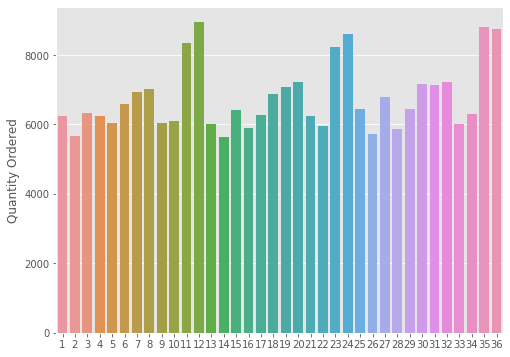

In [7]:
# look at actual month sales

month_sales = df.groupby(['Year', 'Month']).sum().reset_index()
month_sales.index += 1

plt.figure(figsize=(8,6))  # figsize not applying for some reason
ax = sns.barplot(x=month_sales.index, y=month_sales['Quantity Ordered'])

This helps us size the total market. The idea is that we can estimate the total realistic output from the restaurant, and then apply modifiers to decrease from there. 

# 2. What do people spend on orders?

I peeked at yelp too for input and considered scraping them for ratings, but their robot.txt disallows it.

# Improvements

Quantity ordered is big at 1, then 2, then follows a normal distribution after that. It sticks out a bit that as many people ordered 9 quantity of an item as 3 quantity. Maybe a geometric distribution would be more appropriate.

# Data re-generator

I'm going to talk about regenerating data for the A/B test now. Chronologically, this takes place AFTER the analysis and writing out the experiment. If you want to read those first, the links are here:

We regenerate fresh data to simulate collection of user data. 

Current plan is slight random variance in weights, and printing out the weight used to a .txt file which I won't look at until after the analysis. The goal is to evaluate whether or not the value went up or down, and whether it's statistically significant or just noise (e.g. the change we made actually had some impact). 

I'll look at the randomly printed value afterwards to compare. Might make a note: based on the test results, I would say this is statistically significant and would recommend this change going forward. Bonus: since it's a simulation, I'll try to guess the weight (not really sure if this is worth anything since there's so many random variation all over the place, but it's just for fun).